In [1]:
from urllib import request
import zipfile
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.version

'3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]'

Accessing data:

In [3]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

# Exploratory Analysis 

### YOUR TASK:
1. Check readme file (especially DETAILED DESCRIPTIONS OF DATA FILES section)

This data set consists of:
   * 100,000 ratings (1-5) from 943 users on 1682 movies. 
   * Each user has rated at least 20 movies. 

In [4]:
users_num = 943
movies_num = 1682

How our data looks?

In [5]:
df = pd.read_csv('ml-100k/u.data', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)

In [6]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
df.tail()

,user_id,item_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


Check if every pair (user, item) appears only once

In [8]:
df.groupby(['user_id','item_id']).count().reset_index()['timestamp'].max()

1

Check for nan

In [9]:
df['rating'].unique()

array([3, 1, 2, 4, 5])

Ratings distribution

<Axes: ylabel='Frequency'>

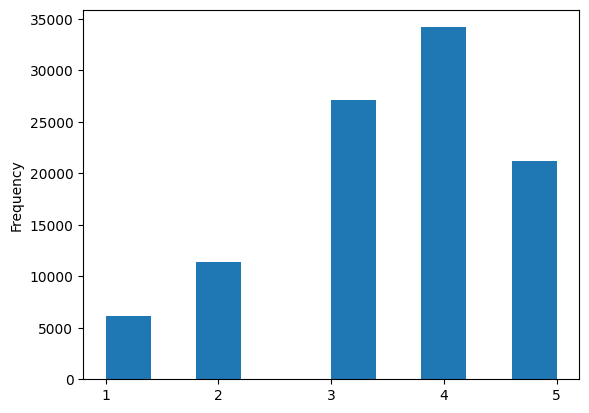

In [10]:
df['rating'].plot.hist(xticks=[1,2,3,4,5])

Choose one movie from u.info file and check its ratings

<Axes: ylabel='Frequency'>

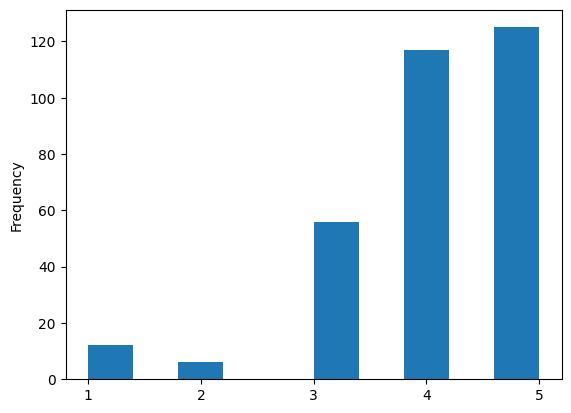

In [11]:
#168 = 'Monty Python and the Holy Grail' 
df[df.item_id == 168]['rating'].plot.hist(xticks=[1,2,3,4,5])

#### Sparsity

In [12]:
grouped = df[['user_id', 'item_id']].groupby('user_id').count() \
            .rename(columns={'item_id' : 'rating_count' }).sort_values('rating_count',ascending=False)
grouped.head()

,rating_count
user_id,
405,737
655,685
13,636
450,540
276,518


In [13]:
grouped['sparsity'] = 1.0 - grouped.rating_count / float(movies_num)
grouped.head()

,rating_count,sparsity
user_id,,
405,737,0.561831
655,685,0.592747
13,636,0.621879
450,540,0.678954
276,518,0.692033


In [14]:
np.average(grouped['sparsity'])

0.9369533063577546

<Axes: ylabel='Frequency'>

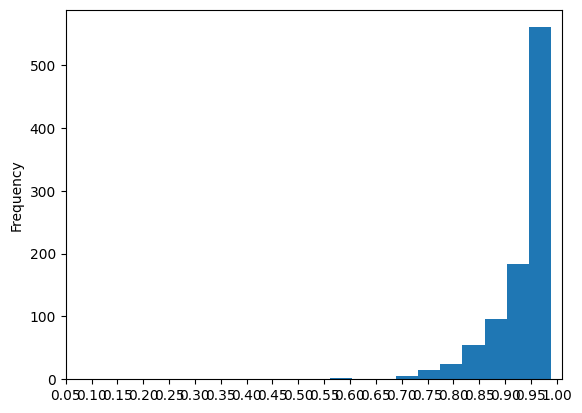

In [15]:
grouped['sparsity'].plot.hist(xticks=[i*0.05 for i in range(1,21)])

<Axes: ylabel='Frequency'>

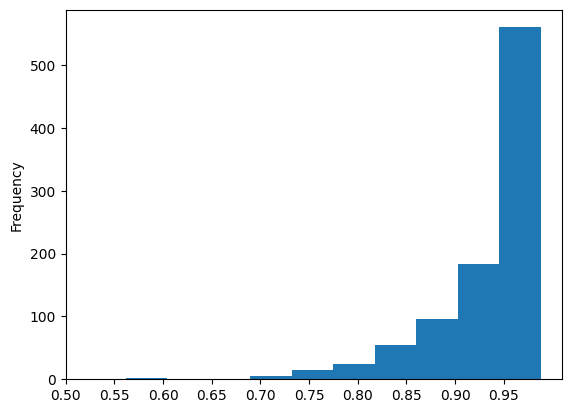

In [16]:
grouped['sparsity'].plot.hist(xticks=[0.5+i*0.05 for i in range(10)])

Reindex ids to numpy's like

In [17]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(1, 943), (1, 1682)]

In [18]:
for col in  ['user_id', 'item_id']:
    df[col] = df[col]-1

In [19]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(0, 942), (0, 1681)]

# User-User CF

Firstly we want to have our data in form of matrix, where rows coresponds to users, columns to items and values to ratings

YOUR TASK:
1. get reccomendation matrix, where users are in rows and movies are in columns
2. What to do with missing values (i.e. pairs of users,movie that have no rating in our dataset)?
3. We want this matrix to be called 'ratings_matrix' and be a np.ndarray type

tip: check dataframe.pivot or pd.crosstab

In [21]:
# Place your code here ~1-2lines
ratings_matrix = np.array(df.pivot(index='user_id', columns='item_id', values='rating').fillna(0).values)
ratings_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

Similarity functions:
* Jackard similarity
* cosine similarity
* Pearson correlation

In [88]:
def jackard_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            vec_sum = float(np.count_nonzero(M[i]+M[j]))
            if vec_sum == 0:
                distance_matrix[i,j] = 1
            else:
                distance_matrix[i,j] = 1 - np.count_nonzero(M[i]*M[j]) / vec_sum
    return distance_matrix

jackard_similarity_distance(ratings_matrix).shape

(943, 943)

## YOUR TASK
1. Implement cosine_similarity_distance based on jackard_similarity_distance
2. Implement scipy_pearson_similarity_distance based on jackard_similarity_distance

In [89]:
def cosine_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.zeros([n,n])
    for i in range(n):
        for j in range(n):    
            if np.count_nonzero(M[i] + M[j]) == 0:
                distance_matrix[i,j] = 1
            else:
                numerator = float(np.sum(M[i]*M[j]))
                denominator = np.sqrt(np.sum(M[i]*M[i]))*np.sqrt(np.sum(M[j]*M[j]))
                if denominator==0:
                    distance_matrix[i,j]= 1
                else:
                    distance_matrix[i,j] = 1 - numerator / float(denominator)
    return distance_matrix

In [90]:
def better_cosine_similarity_distance(M, conf_factor=50.0):
    n,k = M.shape
    conf_factor = float(min(k,conf_factor))
    distance_matrix = np.array(np.zeros(n*n))
    distance_matrix.shape = (n,n)
    for i in range(n):
        for j in range(n):
            vec_sum = float(np.count_nonzero(M[i]+M[j]))
            if(vec_sum==0):
                distance_matrix[i,j] = 1
            else:
                v1 = M[i]
                v2 = M[j]
                nz_idx = np.intersect1d(np.nonzero(v1),np.nonzero(v2))
                #nz_avg = (np.count_nonzero(v1) + np.count_nonzero(v2))/2.0
                if (len(nz_idx)==0):
                    distance_matrix[i,j] = 1
                    continue
                v1 = v1[nz_idx]
                v2 = v2[nz_idx]
                numerator = float(np.sum(v1*v2))
                denominator = np.sqrt(np.sum(v1*v1))*np.sqrt(np.sum(v2*v2))
                if denominator==0:
                     with np.printoptions(threshold=np.inf):
                        print(v1,v2)
                        distance_matrix[i,j] = 1
                else:
                    distance_matrix[i,j] = 1 - np.min([1.0,len(nz_idx)/float(conf_factor)])*numerator/denominator
                #distance_matrix[i,j] = 1 - (len(nz_idx)/nz_avg)*numerator/denominator
    return distance_matrix 

In [91]:
from scipy.stats.stats import pearsonr

def scipy_pearson_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if np.count_nonzero(M[i]*M[j])==0:
                distance_matrix[i,j] = 1
            else:
                distance_matrix[i,j] = 1 - pearsonr(M[i],M[j])[0]
    return distance_matrix

k- nearest neighboors

In [92]:
def knn(ratings_matrix, k, similarity_function):
    dist_matrix = similarity_function(ratings_matrix)
    idx = np.argsort(dist_matrix)[:,1:k+1]
    sorted_dist = np.take_along_axis(dist_matrix, idx, axis=1) #np.sort(dist_matrix)[:,1:k+1]
    return idx, sorted_dist

In [93]:
def calculate_recommendation(ratings_matrix, neighbors, distances):
    u,k = neighbors.shape
    p = ratings_matrix.shape[1]
    rating_matrix_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation_matrix = np.zeros([u,p])
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-distances[i,:])*ratings_matrix[neighbors[i],j])
            denominator = np.sum((1-distances[i,:])*rating_matrix_ind[neighbors[i],j])
            if(denominator==0):
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix

In [94]:
rating_ind = np.array(ratings_matrix!=0, dtype=float)
rating_ind

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [95]:
def get_recommendation(recommendation_matrix, n):
    rating_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation = np.argsort(-np.multiply(recommendation_matrix,1-rating_ind))[:,:n]
    ratings = np.take_along_axis(recommendation_matrix, recommendation, axis=1) 
    return recommendation, ratings

# Item-Item CF

In [96]:
ratings_item_matrix = np.array(df.pivot(index='item_id', columns='user_id', values='rating').fillna(0).values)
ratings_item_matrix

array([[5., 4., 0., ..., 5., 0., 0.],
       [3., 0., 0., ..., 0., 0., 5.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
ratings_item_ind = np.array(ratings_item_matrix!=0, dtype= float)

In [98]:
def calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances): # to get arguments run previous knn 
    # on ratings_item_matrix
    p,k = item_neighbors.shape
    u = ratings_matrix.shape[0]
    rating_matrix_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation_matrix = np.array(np.zeros(u*p))
    recommendation_matrix.shape = (u,p)
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-item_distances[j,:])*ratings_matrix[i,item_neighbors[j]])
            denominator = np.sum((1-item_distances[j,:])*rating_matrix_ind[i, item_neighbors[j]])
            if(denominator==0):
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix

In [99]:
item_neighbors, item_distances = knn(ratings_item_matrix, 3, cosine_similarity_distance)

In [100]:
recommendation_matrix = calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances)

### RMSE

In [101]:
def rmse(ratings_matrix,recommendation_matrix, test_ind):
    X = np.multiply((ratings_matrix-recommendation_matrix), test_ind)
    Y = np.sum(np.multiply(X,X))
    Z= np.sum(test_ind)
    return np.sqrt(Y / Z)

# Testing

In [102]:
train_1 = pd.read_csv('ml-100k/u1.base', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)
test_1 = pd.read_csv('ml-100k/u1.test', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)

In [103]:
for col in  ['user_id', 'item_id']:
    train_1[col] = train_1[col]-1
    test_1[col] = test_1[col]-1

In [104]:
train_1_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train_1['user_id'],categories = [i for i in range(943)]), 
                              columns=pd.Categorical(train_1['item_id'],categories = [i for i in range(1682)]),
                             values=train_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
test_1_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test_1['user_id'],categories = [i for i in range(943)]), 
                              columns=pd.Categorical(test_1['item_id'],categories = [i for i in range(1682)]),
                             values=test_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

In [105]:
train_1_if_filled = np.array(train_1_ratings_matrix!=0, dtype=float)
test_1_if_filled = np.array(test_1_ratings_matrix!=0, dtype=float)

Check if train + test is equal to full data_set

In [106]:
np.all(train_1_if_filled+test_1_if_filled == (ratings_matrix!=0))

True

In [107]:
neighbors, distances = knn(train_1_ratings_matrix, 3, cosine_similarity_distance)

In [108]:
recommendation_matrix = calculate_recommendation(train_1_ratings_matrix, neighbors, distances)

In [109]:
ratings_matrix_ind =  np.array(ratings_matrix!=0, dtype=float)

In [110]:
a,b =ratings_matrix_ind.shape
print (a,b)
dumb_pred = np.random.randint(1,6, size=a*b)
dumb_pred.shape=(a,b)
dumb_pred

943 1682


array([[4, 4, 4, ..., 5, 2, 4],
       [3, 1, 1, ..., 2, 2, 1],
       [3, 2, 3, ..., 1, 1, 1],
       ...,
       [1, 3, 2, ..., 3, 2, 5],
       [1, 1, 4, ..., 2, 1, 1],
       [2, 2, 2, ..., 5, 2, 1]])

In [111]:
rmse(ratings_matrix, dumb_pred,ratings_matrix_ind)

1.878895952414609

In [112]:
rmse(ratings_matrix, ratings_matrix,ratings_matrix_ind)

0.0

# Validation

In [113]:
def cross_val_testing(ratings_matrix):
    results =[]
    print("start")
    for ii in range(1,6):
        iter_start_time = time.time()
        #if(ii!=3):
        #    continue
        train = pd.read_csv('ml-100k/u{}.base'.format(ii), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
        test = pd.read_csv('ml-100k/u{}.test'.format(ii), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)

        for col in  ['user_id', 'item_id']:
            train[col] = train[col]-1
            test[col] = test[col]-1
        
        train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(943)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(943)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1682)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        
        train_ratings_item_matrix = np.array(pd.crosstab(index=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]), 
                                                    columns=pd.Categorical(train['user_id'],categories = [i for i in range(943)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)       
        
        train_ind = np.array(train_ratings_matrix!=0, dtype=float)
        test_ind = np.array(test_ratings_matrix!=0, dtype=float)
        
        print('Precalc time: ',  round((time.time()-iter_start_time)/60.0,3) )
        
        for k in [5,7,40]:        
            for function_name,dist_function in zip(['jackard','cosine','better_cosine','pearson'],[jackard_similarity_distance, cosine_similarity_distance, better_cosine_similarity_distance, scipy_pearson_similarity_distance]):
                for cf_type,rec_fun in zip(['u-u','i-i'],[calculate_recommendation, calculate_recommendation_item_based]):                       
                    start_time = time.time()
                    neighbors, distances = knn(train_ratings_matrix, k, dist_function) if cf_type =='u-u' \
                                        else knn(train_ratings_item_matrix, k, dist_function)
                    recommendation_matrix = rec_fun(train_ratings_matrix, neighbors, distances)
                    rmse_val = rmse(ratings_matrix, recommendation_matrix, test_ind)                    
                    results.append([ii,cf_type,function_name,k, rmse_val, round((time.time()-start_time)/60.0,3)])
                    print ([ii,cf_type,function_name,k, rmse_val, round((time.time()-start_time)/60.0,3)])
        print("Iter time: ", iter_start_time)
    return results

In [ ]:
result = cross_val_testing(ratings_matrix) 

start
Precalc time:  0.882
[1, 'u-u', 'jackard', 5, 2.0678695642161955, 0.753]
[1, 'i-i', 'jackard', 5, 2.07939881363725, 1.105]
[1, 'u-u', 'cosine', 5, 1.790693004650543, 1.066]
[1, 'i-i', 'cosine', 5, 1.987919719749416, 2.12]
[1, 'u-u', 'better_cosine', 5, 1.6600860504577652, 1.824]
[1, 'i-i', 'better_cosine', 5, 2.052101876181985, 3.644]
[1, 'u-u', 'pearson', 5, 1.9115458766052564, 1.577]
[1, 'i-i', 'pearson', 5, 2.2035608655094836, 2.59]
[1, 'u-u', 'jackard', 7, 1.87967003015912, 0.755]
[1, 'i-i', 'jackard', 7, 1.8555065138352604, 1.105]
[1, 'u-u', 'cosine', 7, 1.6265023101116074, 1.067]
[1, 'i-i', 'cosine', 7, 1.7743913471075559, 2.08]
[1, 'u-u', 'better_cosine', 7, 1.499771431941783, 1.822]
[1, 'i-i', 'better_cosine', 7, 1.8150402534456915, 3.65]
[1, 'u-u', 'pearson', 7, 1.7415663027302923, 1.577]
[1, 'i-i', 'pearson', 7, 1.9708087128290266, 2.599]
[1, 'u-u', 'jackard', 40, 1.2268218018519588, 0.768]
[1, 'i-i', 'jackard', 40, 1.1573506315428252, 1.112]
[1, 'u-u', 'cosine', 40, 1.